<a href="https://colab.research.google.com/github/phongvu009/NLP_mlp_basic_1/blob/main/mlp_make_more_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [ ]:
words = open('names.txt',mode='r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
#build alphabet
alphabet = sorted(list(set(''.join(words))))

#string to index
stoi = {char:idx+1 for idx,char in enumerate(alphabet)}
#add . character
stoi['.'] = 0

#index to string
itos = {idx:char for char,idx in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Build Dataset:

In [ ]:
import random

In [ ]:
random.seed(42)
random.shuffle(words)
print(len(words))
n1 = int(0.8 * len(words)) # idx number at 80% of data
print(n1)
n2 = int(0.9 * len(words))
print(n2)

32033
25626
28829


In [ ]:

def build_dataset(words):
  block_size = 3
  X,Y = [],[]
  for word in words:
    context = [0] * block_size
    for chr in word + '.':
      #get index
      idx = stoi[chr]
      X.append(context)
      Y.append(idx)
      #update context
      context = context[1:] + [idx]
  #tranform to tensor
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

In [ ]:
# 80% is training set
X_train, Y_train = build_dataset(words[:n1])

#10% is dev/evaluate set
X_dev , Y_dev = build_dataset(words[n1:n2])

#10% is testing set
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Initialize Weights

In [ ]:
g = torch.Generator().manual_seed(2147483647)

#Embbeding layer : 10 features
C = torch.randn( (27,10), generator=g)

#Hidden Layer 1
W1 = torch.randn( (30,200), generator=g)
b1 = torch.randn( 200 ,generator=g)

#output layer
W2 = torch.randn( (200,27), generator=g)
b2 = torch.randn( 27, generator=g)

parameters = [C,W1,b1,W2,b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

## Training

In [ ]:
# require gradient tracking:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0 , 1000)
lrs = 10**lre

In [ ]:

lossi = []
stepi = []

In [ ]:

for i in range(200000):
  #create mini-batch
  batch = torch.randint(0, X_train.shape[0], (32,))
  #forward pass
  #embedding
  emb = C[X_train[batch]]
  before_h = emb.view(-1,30) @ W1 + b1
  h = torch.tanh(before_h)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Y_train[batch])
  #backward pass
  for p in parameters: #reset gradient
    p.grad = None
  loss.backward()
  #update
  lr = 0.1 if i < 100000 else 0.01 # use flex learning rate
  for p in parameters:
    p.data += -lr * p.grad
  #track stats
  lossi.append(loss.log10().item())
  stepi.append(i)
print(f'loss is : {loss.item()}')


loss is : 2.046438217163086


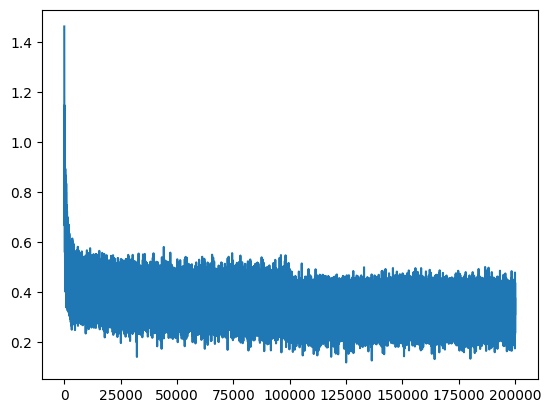

In [ ]:
plt.plot(stepi,lossi)

## Evaluate Model

In [ ]:
emb = C[X_train]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_train)
print(loss)

tensor(2.1507, grad_fn=<NllLossBackward0>)


In [ ]:
emb = C[X_dev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y_dev)
loss

tensor(2.1810, grad_fn=<NllLossBackward0>)

## Get Sample After Training

In [ ]:
block_size = 3
context  = [0] * block_size
print(context)
print(f'C shape : {C.shape}')
x_sample = C[torch.tensor([context])]
print(f'input shape: {x_sample.shape}')
print(f'transform input shape : {x_sample.view(1,-1).shape}')
x_sample.shape

[0, 0, 0]
C shape : torch.Size([27, 10])
input shape: torch.Size([1, 3, 10])
transform input shape : torch.Size([1, 30])


torch.Size([1, 3, 10])

In [ ]:
x = torch.tensor( [ [0.1,0.2,0], [0,0,0]])
print(x)
print(x.shape)
print(x.shape[0])

tensor([[0.1000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000]])
torch.Size([2, 3])
2


In [ ]:
#sample
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0] * block_size

  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits,dim=1) #compute softmax of columnsalong each row
    #sample from distribution
    ix = torch.multinomial(probs,num_samples=1, generator=g).item()
    out.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break

  word_pred = ''.join(itos[i] for i in out)
  print(word_pred)

mora.
mayah.
seel.
nihah.
lorethrusendrari.
azeerdielin.
shi.
jen.
eden.
estanareelyn.
malkes.
noshdenrishiriel.
kinleenellennteromi.
brence.
riyah.
fiel.
yule.
mis.
kyla.
hil.
